(1, 200) (1, 200)
(1, 50) (1, 50)


<IPython.core.display.Javascript object>


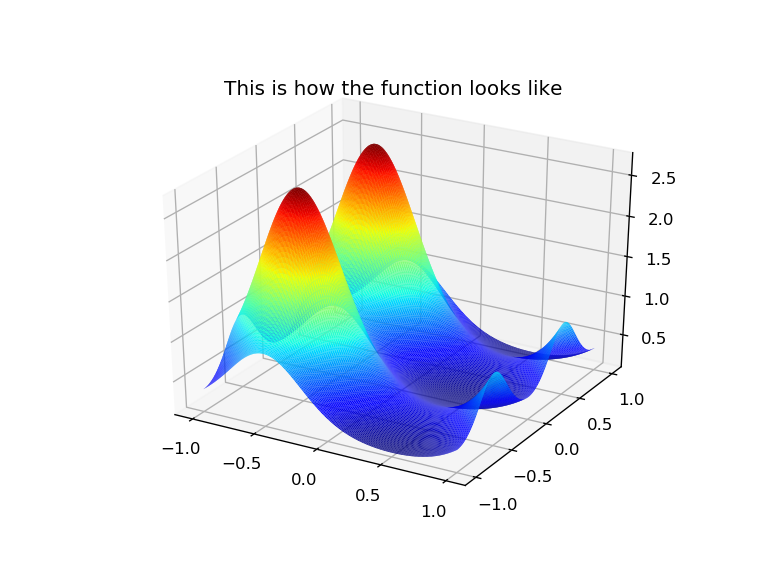

Text(0.5,0.92,'This is how the function looks like')

In [59]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.tri as mtri
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
# %matplotlib inline

def sample_function(u,v):
    return np.exp(-(np.sin(np.pi*u)+np.cos(np.pi*v)**2))
    


%matplotlib notebook
num_div=200
num_divcv=50
x=np.linspace(-1, 1, num=num_div).reshape(1,num_div)
y=np.linspace(-1, 1, num=num_div).reshape(1,num_div)
# creat random number from -1 to 1 for the corss validation set
x_cv=np.sort(np.random.rand(1,num_divcv))*2-1
y_cv=np.sort(np.random.rand(1,num_divcv))*2-1
u_cv, v_cv = np.meshgrid(x_cv, y_cv)

print(x.shape, y.shape)
print(x_cv.shape, y_cv.shape)

u, v = np.meshgrid(x, y)
z=sample_function(u ,v)
z_cv=sample_function(u_cv ,v_cv)
# plot the function to see how it looks
fig = plt.figure()
ax = plt.axes(projection='3d')
plt.xticks(np.linspace(-1,1,5))
plt.yticks(np.linspace(-1,1,5))
ax.plot_surface(u, v, z, cmap=plt.cm.jet, rstride=1, cstride=1)
plt.title('This is how the function looks like')


In [60]:
X=np.zeros([u.shape[0]*v.shape[0],2])
Xcv=np.zeros([u_cv.shape[0]*v_cv.shape[0],2])

print(X.shape)
X[:,0]=u.reshape(u.shape[0]*u.shape[1])
X[:,1]=v.reshape(v.shape[0]*v.shape[1])
y=z.reshape(z.shape[0]*z.shape[1],1)
Xcv[:,0]=u_cv.reshape(u_cv.shape[0]*u_cv.shape[1])
Xcv[:,1]=v_cv.reshape(v_cv.shape[0]*v_cv.shape[1])
ycv=z_cv.reshape(z_cv.shape[0]*z_cv.shape[1],1)

print(y.shape)
num_features=X.shape[1]
num_train=X.shape[0]
print('num_features : %d , num_train: %d, num_validation: %d' % (num_features, num_train,ycv.shape[0]))

def error(pred, labels):
  return np.mean(np.abs(pred-labels)/labels)*100

error((np.random.rand(5,1)*0.05+1)*np.ones(5),np.ones(5))

(40000, 2)
(40000, 1)
num_features : 2 , num_train: 40000, num_validation: 2500


1.8785416907752241

In [61]:
n_hidden1 = 200
n_hidden2 = 20
reg=0
graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,shape=(None, num_features))
  tf_train_labels = tf.placeholder(tf.float32, shape=(None, 1))
  
  # Variables.
  W1 = tf.Variable(tf.random_normal([num_features, n_hidden1],0,0.02))
  W2 = tf.Variable(tf.random_normal([n_hidden1, n_hidden2],0,0.02))
  W3 = tf.Variable(tf.random_normal([n_hidden2, 1],0,0.02))

  b1 = tf.Variable(tf.zeros([1,n_hidden1]))
  b2 = tf.Variable(tf.zeros([1,n_hidden2]))
  b3 = tf.Variable(tf.zeros([1]))

  # Training computation.
  layer1 = tf.matmul(tf_train_dataset, W1) + b1
  a_1=tf.nn.softmax(layer1)#(num_train,n_hidden1)
  layer2 = tf.matmul(a_1, W2) + b2 #(num_train,n_hidden)x(n_hidden, 1)+(1,1)
  a_2=tf.nn.softmax(layer2)#(num_train,n_hidden2)
  layer3=tf.matmul(a_2, W3) + b3
  train_prediction=layer3

    
  print('prediction shape is' , train_prediction.shape, 'y shape is ',tf_train_labels.shape )
  loss = tf.reduce_mean((train_prediction-tf_train_labels)*(train_prediction-tf_train_labels))#\
#           + (tf.nn.l2_loss(W1*W1)+tf.nn.l2_loss(W2*W2)+tf.nn.l2_loss(W3*W3))*reg

  # Optimizer.
  optimizer = tf.train.AdamOptimizer(0.001).minimize(loss)
  valid_prediction = layer3

  # Predictions for the training, validation, and test data.
#   train_prediction = output
#   test_prediction = tf.matmul(tf.nn.relu(tf.matmul(tf_test_dataset, W1) + b1),
#                                W2)+b2
    
    
num_steps = 20000

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.

    feed_dict = {tf_train_dataset : X, tf_train_labels : y}
    _,p,l= session.run([optimizer, train_prediction,loss], feed_dict=feed_dict)
    if (step % 500 == 0):
      feed_dictcv = {tf_train_dataset : Xcv, tf_train_labels : ycv}
      cvPred= session.run([valid_prediction], feed_dict=feed_dictcv)
      print("Minibatch loss at step %d: %f" % (step, l))
      print('Training Error: %f, Validation Error: %f' % ( error(p, y), error(cvPred, ycv) ))
#     if (error(cvPred, ycv)<1):
#         break
      newy=p.reshape(num_div,num_div)
      newycv=np.array(cvPred).reshape(num_divcv,num_divcv)
    

prediction shape is (?, 1) y shape is  (?, 1)
Initialized
Minibatch loss at step 0: 1.052033
Training Error: 99.593932, Validation Error: 99.134305
Minibatch loss at step 500: 0.401317
Training Error: 93.433497, Validation Error: 97.768282
Minibatch loss at step 1000: 0.225334
Training Error: 75.518948, Validation Error: 76.709129
Minibatch loss at step 1500: 0.167321
Training Error: 43.814021, Validation Error: 44.456055
Minibatch loss at step 2000: 0.164202
Training Error: 42.626417, Validation Error: 43.580896
Minibatch loss at step 2500: 0.161653
Training Error: 42.246024, Validation Error: 43.472742
Minibatch loss at step 3000: 0.158747
Training Error: 41.445794, Validation Error: 42.830637
Minibatch loss at step 3500: 0.154554
Training Error: 39.792575, Validation Error: 41.219524
Minibatch loss at step 4000: 0.144224
Training Error: 33.057661, Validation Error: 34.680187
Minibatch loss at step 4500: 0.129541
Training Error: 33.236259, Validation Error: 31.949043
Minibatch loss a

<IPython.core.display.Javascript object>


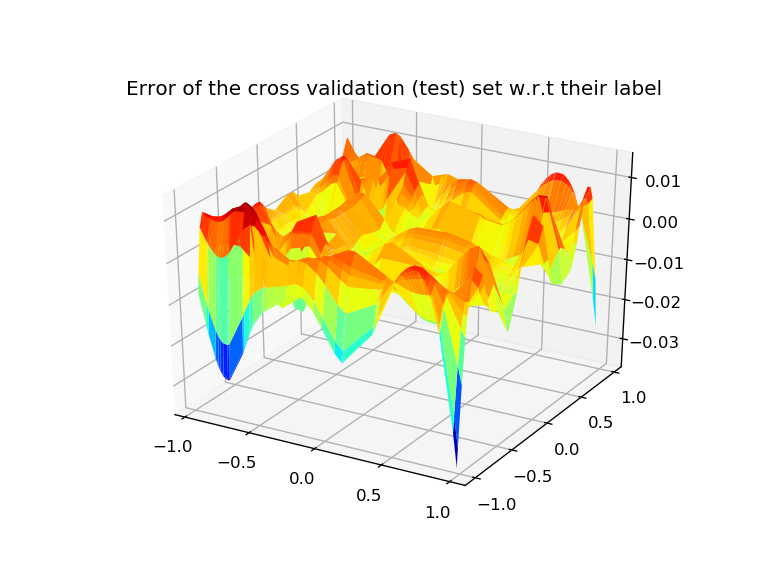

<IPython.core.display.Javascript object>


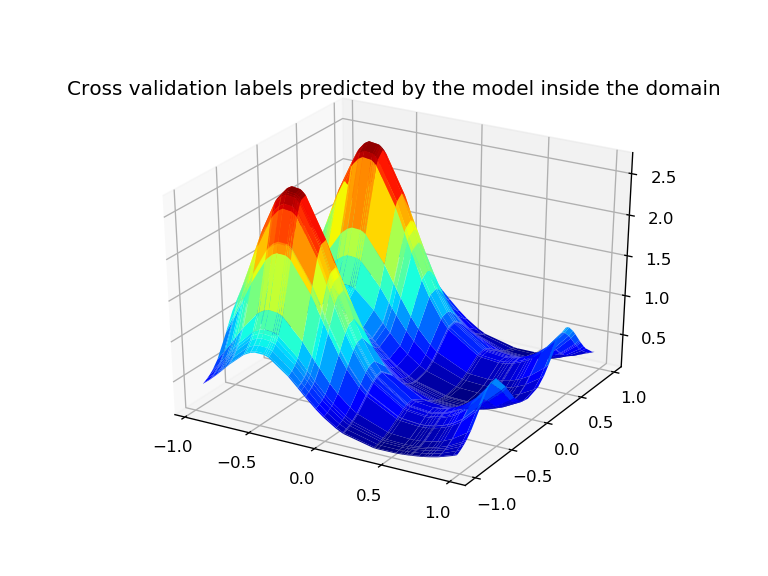

Text(0.5,0.92,'Cross validation labels predicted by the model inside the domain')

In [62]:
# now plot the whatever we have learned 
fig = plt.figure()
ax = plt.axes(projection='3d')
plt.xticks(np.linspace(-1,1,5))
plt.yticks(np.linspace(-1,1,5))
#ax.plot_surface(u, v, z, cmap=plt.cm.jet, rstride=1, cstride=1, linewidth=0)
# ax.plot_surface(u, v, newy, cmap=plt.cm.jet, rstride=1, cstride=1, linewidth=0)
ax.plot_surface(u_cv, v_cv, newycv-z_cv, cmap=plt.cm.jet, rstride=1, cstride=1, linewidth=0)
plt.title('Error of the cross validation (test) set w.r.t their label')


fig = plt.figure()
ax = plt.axes(projection='3d')
plt.xticks(np.linspace(-1,1,5))
plt.yticks(np.linspace(-1,1,5))
#ax.plot_surface(u, v, z, cmap=plt.cm.jet, rstride=1, cstride=1, linewidth=0)
ax.plot_surface(u_cv, v_cv, newycv, cmap=plt.cm.jet, rstride=1, cstride=1, linewidth=0)
plt.title('Cross validation labels predicted by the model inside the domain')

